# Test Network on SnakeCLEF 2021 Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from src.core import models, training, data, metrics
from src.utils import nb_setup, io

DATA_DIR = 'data/snake_clef2021_dataset/'
TRAIN_SET_DIR = 'train'

MODEL_ARCH = 'efficientnet_b0'
MODEL_NAME = 'baselines_mini/clef2021_efficientnet_b0_ce_11-10-2021_11-09-53'

nb_setup.init()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## Load the Data

In [2]:
# load metadata
valid_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_test_metadata_cleaned.csv')

classes = np.unique(valid_df['binomial'])
no_classes = len(classes)
print(f'No classes: {no_classes}')
print(f'Test set length: {len(valid_df):,d}')

No classes: 770
Test set length: 26,227


In [3]:
species = np.unique(valid_df['binomial'])
countries = np.unique(valid_df['country'].fillna('unknown'))

# load country-species map and create country f1 score metric
country_map_df = pd.read_csv(DATA_DIR + 'species_to_country_mapping.csv', index_col=0)
country_weights = metrics.clean_country_map(country_map_df, species, missing_val=0)
country_f1_score = metrics.CountryF1Score(country_weights)

# create country-species weight for adjusting predictions
country_lut = io.read_json(DATA_DIR + 'country_lut.json')
country_weights_adj = metrics.clean_country_map(
    country_map_df.rename(columns=country_lut), species, countries, missing_val=1)

## Create Network and Dataloader

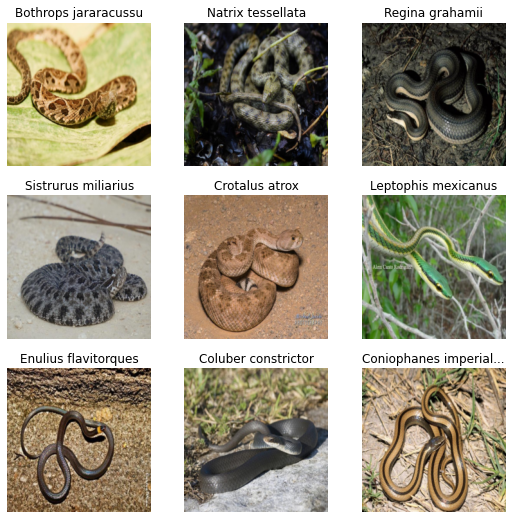

In [4]:
# create fine-tuned network
model = models.get_model(MODEL_ARCH, no_classes, pretrained=False)
training.load_model(model, MODEL_NAME, path=DATA_DIR + 'models')
assert np.all([param.requires_grad for param in model.parameters()])

model_config = model.pretrained_config
batch_size = 128

# create transforms
_, valid_tfms = data.get_transforms(
    size=model_config['input_size'], mean=model_config['image_mean'],
    std=model_config['image_std'])

# create data loaders
validloader = data.get_dataloader(
    valid_df, img_path_col='image_path', label_col='binomial',
    path=DATA_DIR + TRAIN_SET_DIR, transforms=valid_tfms, labels=classes,
    batch_size=batch_size, shuffle=False, num_workers=4)

validloader.dataset.show_items()

## Create Predictions

In [5]:
# create predictions
pred, targ, _ = training.predict(model, validloader)

In [6]:
# compute scores
scores = training.classification_scores(pred, targ)
scores['country_f1_score'] = country_f1_score(pred.argmax(1), targ)
pd.Series(scores).round(3) * 100

accuracy            69.1
top_3               80.7
f1_score            57.5
country_f1_score    54.4
dtype: float64

In [7]:
from src.core import calibration

# tune temperature
temperature = calibration.tune_temperature(model, validloader)

Before temperature - NLL: 1.480
Optimal temperature: 1.441
After temperature - NLL: 1.375


## Adjust Predictions using Country

In [8]:
df = valid_df.copy()
df['country'] = df['country'].fillna('unknown')
bin_map = country_weights_adj.loc[:, df['country']].values.T

pred_adj = pred * bin_map

In [9]:
# compute scores
scores_adj = training.classification_scores(pred_adj, targ)
scores_adj['country_f1_score'] = country_f1_score(pred_adj.argmax(1), targ)
_df = pd.DataFrame({'before': scores, 'after': scores_adj}).T
_df.loc['diff'] = (_df.loc['after'] - _df.loc['before'])
_df.round(3) * 100

,accuracy,top_3,f1_score,country_f1_score
before,69.1,80.7,57.5,54.4
after,76.0,89.4,64.8,66.3
diff,6.9,8.6,7.3,11.9
